# Imports, Power Spectra Compilation, and simulation (+CosMomentum) data loading

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from math import *
from scipy import integrate
from scipy.optimize import fsolve
from classy import Class
from astropy.io import fits

import scienceplots
plt.style.use(['science','nature'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = [5,3]
plt.rcParams['lines.linewidth'] = 0.8

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
# Choose your cosmology, redshift, Radius, and delta of interest

#Quijote Cosmologyical parameters
Omega_m = 0.3175
Omega_b = 0.049
h = 0.6711
n_s = 0.9624
sigma8 = 0.834

# Redshift
z = 0.5
# Radius
R = 10.0

In [8]:
# Delta_R
del_R = np.linspace(-0.99,120,num=2**12)
del_L = inverse_of_approximate_collapse_alex(del_R)
del_L_max = np.max(del_L)
del_L_min = np.min(del_L)
print(del_L_max)
print(del_L_min)



# Computing the power spectra
k_l,pk_l,k_nl,pk_nl = generate_all_power_spectra(Omega_m,
                                                 Omega_b,
                                                 h,
                                                 n_s,
                                                 sigma8,
                                                 z)

# Sigma generation, and testing of function
sR = sigma_from_power_spectrum(k_l, pk_l, R)
sR2 = np.square(sR)
print(sR)
print(sR2)
print(sigma_from_power_spectrum(k_nl, pk_nl, R))

1.5324124130108996
-26.333931165972125
generating power spectra ... (this will take time) ...
Done!
0.5451167532675768
0.2971522746929842
0.573506343457524


In [9]:
del_qui, pdf_qui, std_qui = load_quijote_sim("Quijote_PDFs_15000_512CDMparticles/quijote_PDF_z"+str(z)+"_R"+str(R)+".npy",realisations=15000)

In [11]:
# Loading data generated by Cosmomentum
CM_delta = np.load("CosMom/delta_quijote_z"+str(z)+"_R"+str(int(R))+"_CosMom.npy")
CM_PDF = np.load("CosMom/PDF_quijote_z"+str(z)+"_R"+str(int(R))+"_CosMom.npy")

# Generating the CGF

In [13]:
delta_L, lam, cgf, cgfp, cgfpp, Psi_from_legendre = RCGF_at_the_saddle(k_l, pk_l, k_nl, pk_nl, R)

In [14]:
# comparing variance to cumulant
print(np.interp(0,lam,cgfpp))
print(np.square(sigma_from_power_spectrum(k_nl, pk_nl, R)))

0.3289095567851671
0.3289095259860195


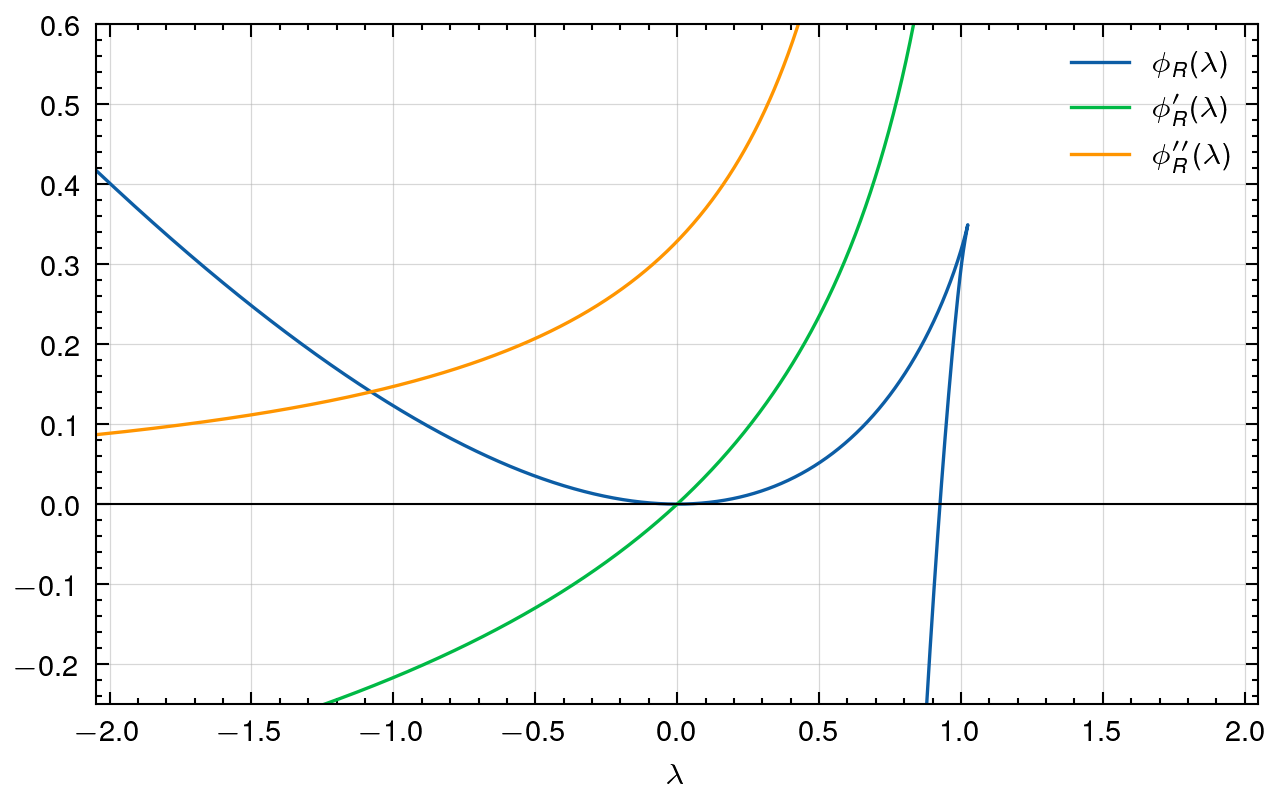

In [15]:
N = 500
max_lam = np.nanmax(lam)

plt.plot(lam[:-N],cgf[:-N],label=r'$\phi_{R}(\lambda)$')#, c=colors[0], ls='dashed')
plt.plot(lam[:-N],cgfp[:-N],label=r'$\phi^{\prime}_{R}(\lambda)$')#, c=colors[1], ls='dashed')
plt.plot(lam[:-3*N],cgfpp[:-3*N],label=r'$\phi^{\prime \prime}_{R}(\lambda)$')#,c=colors[2], ls='dotted')

plt.plot(np.linspace(-10,10,2),[0,0],c='k',lw=0.5)

# plt.plot(np.linspace(-10,10,1000),0.5*(np.square(sigma_from_power_spectrum(k_nl, pk_nl, R)))*np.square(np.linspace(-10,10,1000)),label="$\sigma_{NL,10}^2x^2 / 2$",c = 'grey',ls='dashed')

# lam_cm = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/lamda_R10_z05.npy")
# cgf_cm = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/cgf_R10_z05.npy")
# plt.plot(lam_cm[::4],cgf_cm[::4],lw=0,label="CosMomentum",marker='s',markersize=2)#,c=colors[3])

plt.xlim([-max_lam*2,max_lam*2])
plt.ylim([-0.25,0.6])
# plt.xlim(-3,2)
# plt.ylim([-0.25,0.8])

plt.xlabel(r'$\lambda$')
# plt.ylabel(r'$\phi_R(\lambda)$')
plt.grid(alpha=0.5,lw=0.3)
plt.legend()
# plt.title("RCGF and its second derivative")
# plt.savefig("figs5/CGF_z="+str(z)+"_R="+str(R)+".pdf")

In [14]:
# Getting cumulants
print(sigma_from_power_spectrum(k_nl, pk_nl, R)**2 - np.interp(0,lam,cgfpp))
print(np.interp(0,lam,cgf))
print(np.interp(0,lam,cgfp))
print(np.interp(0,lam,cgfpp))

-6.7438155060273175e-09
3.248310172662233e-08
-1.2582292195555751e-07
0.60223577496716


/scratch-local/slurm-job-tmp-4648432/ipykernel_1195/429394480.py:5: RuntimeWarning: invalid value encountered in sqrt
  pdf_saddle = np.exp( ratio*((-lam*cgfp) + cgf) ) / np.sqrt(2 * np.pi * cgfpp * (1/ratio))


Text(0, 0.5, '$\\mathcal{P}(\\delta_R)$')

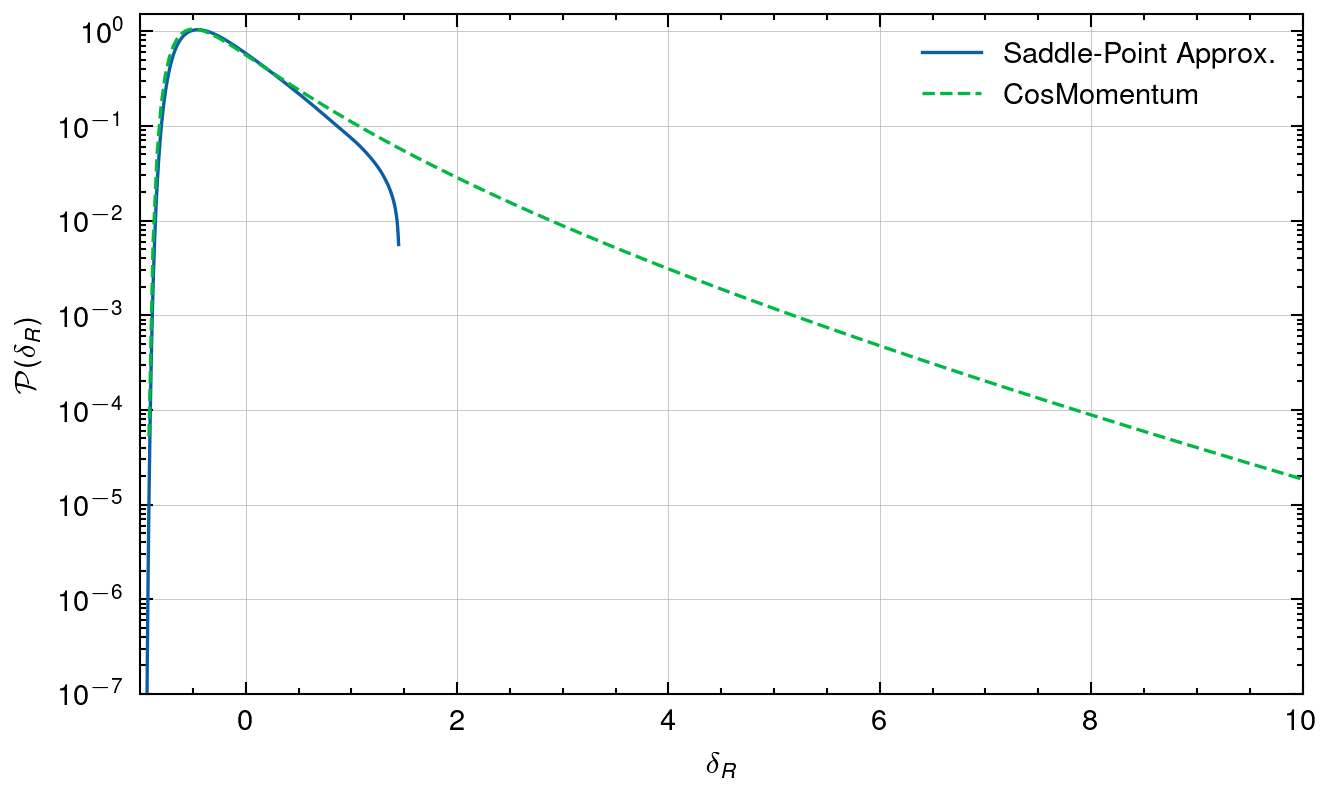

In [15]:
# Saddle point approx
VLR  = np.square(sigma_from_power_spectrum(k_l, pk_l, R))
VR  = np.square(sigma_from_power_spectrum(k_nl, pk_nl, R))
ratio = VR / VLR
pdf_saddle = np.exp( ratio*((-lam*cgfp) + cgf) ) / np.sqrt(2 * np.pi * cgfpp * (1/ratio))

# del_normal,p_normal = normal_distribution(del_R,sigma_from_power_spectrum(k_nl, pk_nl, R),0)
# plt.plot(del_normal,p_normal,label=r'$\mathcal{N}(1,\sigma_{L,R}^2)$',c='k',ls='--',alpha=0.6)

plt.plot(cgfp,pdf_saddle, label="Saddle-Point Approx.", c = colors[0])#,marker = 's',ms=0.5)
plt.plot(CM_delta,       CM_PDF,   label='CosMomentum', ls = "dashed", c = colors[1])
# plt.errorbar(del_qui,pdf_qui,
#              yerr=std_qui,
#              elinewidth = 0.2,
#              linewidth = 0.1,
#              marker = "s",
#              markersize = 0.01,
#              capsize = 3,
#              capthick = 0.2,
#              c = "k",
#              label = "Quijote/z=0.5/R=10",
#              alpha=0.9)

plt.yscale("log")
# plt.xscale("log")
plt.xlim([-1, 10])
plt.ylim([1e-7, 1.5])
plt.legend()
plt.grid(alpha=0.8,lw=0.2)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')
# plt.savefig("saddlevsilt.pdf")

# Critical Density Asymptotics

In [17]:
rho_num_deriv,p_num_deriv = characteristic_function_from_definition(del_R, k_l, pk_l, k_nl, pk_nl, R)

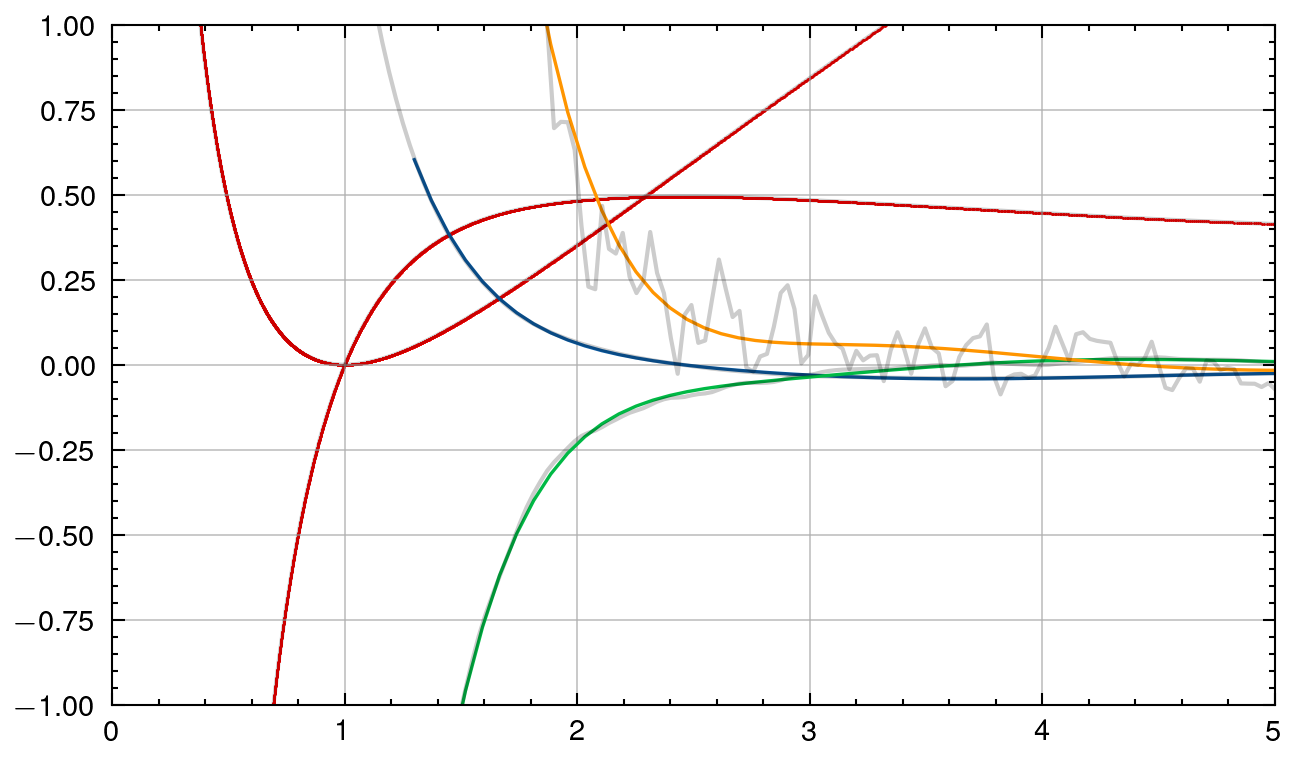

In [19]:
# Comparing to an alternative manner of computing them

rank = 15
r_poly = np.linspace(1.3,20,2**8)


psi0_poly = np.polyfit(r_poly, np.interp(r_poly,rho_num_deriv,p_num_deriv[2,:]), rank)

plt.plot(rho_num_deriv,p_num_deriv[0,:],alpha=0.2,c='k',lw=1)
plt.plot(rho_num_deriv,p_num_deriv[1,:],alpha=0.2,c='k',lw=1)

plt.scatter(cgfp[1:-1]+1,Psi_from_legendre[0,:],lw=0, s = 0.5, c='r', label = r'$\Psi^{(0)}(\rho)$')
plt.scatter(cgfp[1:-1]+1,Psi_from_legendre[1,:],lw=0, s = 0.5, c='r', label = r'$\Psi^{(0)}(\rho)$')

for i in range(3):
    plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=i),r_poly))
    plt.plot(rho_num_deriv,p_num_deriv[i+2,:],alpha=0.2,c='k',lw=1)
plt.ylim([-1,1])
plt.xlim([0,5])
plt.grid(alpha=0.8,lw=0.4)

[3.21286059+0.j         2.92868634+0.42848186j 2.92868634-0.42848186j
 2.45043712+0.j         2.21311872+0.49683407j 2.21311872-0.49683407j
 1.69627278+0.j        ]


(0.0, 5.0)

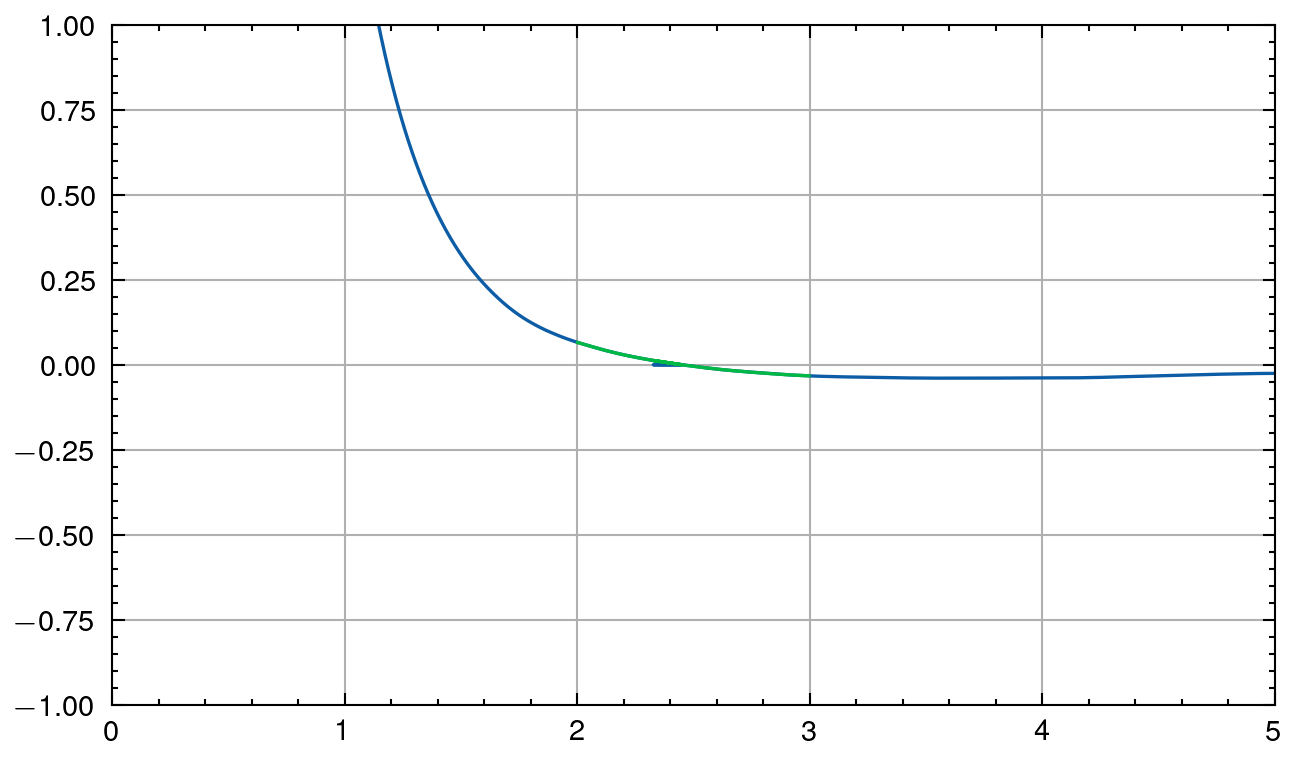

In [21]:
# Visual aid for find the root
rr = cgfp[1:-N-1]+1
cc = Psi_from_legendre[2,0:-N]

location = np.where((rr>2) & (rr<3))

pp = np.polyfit(rr[location], cc[location], 7)
print(np.roots(pp))

plt.plot(cgfp[1:-N-1]+1,Psi_from_legendre[2,0:-N],label=r'$\Psi^{(2)}_{10}(\rho)$')
plt.plot(rr[location],np.polyval(pp,rr[location]))
plt.ylim([-1,1])
plt.grid()
plt.xlim([0,5])

In [22]:
rho_c = 2.45043712 # from above cell (manually)
print(np.interp(lam_c, lam, cgfp))

pi_3 = np.array(np.polyval(np.polyder(psi0_poly,m=1+0),rho_c),dtype=np.complex_)
pi_4 = np.array(np.polyval(np.polyder(psi0_poly,m=2+0),rho_c),dtype=np.complex_)
pi_5 = np.array(np.polyval(np.polyder(psi0_poly,m=3+0),rho_c),dtype=np.complex_)
pi_6 = np.array(np.polyval(np.polyder(psi0_poly,m=4+0),rho_c),dtype=np.complex_)
pi_7 = np.array(np.polyval(np.polyder(psi0_poly,m=5+0),rho_c),dtype=np.complex_)


a32 = (2/3) * np.sqrt(2 / pi_3)
a52 = (np.power(1/pi_3, 7/2) * (5*np.square(pi_4) - 3*pi_3*pi_5)) / (45*sqrt(2))
a2  = -pi_4 / (6*np.square(pi_3))
a72 = (np.power(1/pi_3,13/2) * ( (385*np.power(pi_4,4)) - (630*pi_3*pi_5*np.power(pi_4,2) + (168*pi_6*pi_4*np.power(pi_3,2) + (3*np.power(pi_3,2)*((35*np.power(pi_5,2)) - (8*pi_3*pi_7))))) )) / (7560*sqrt(2))

r1 = -(np.imag(a52)/np.imag(a32)) - rho_c
r2 = -(7*((2*a2*np.power(a32,2)) + (2*a72*a32) - (np.power(a52,2)))) / (4*np.power(a32,2))

P_1 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv,5/2) )
P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + r1,5/2) )
P_3 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + np.absolute(r1) + (np.absolute(r2)/rho_num_deriv),5/2))

# P_46 = (1/sqrt(2*pi)) * np.sqrt(p_num_deriv[2,:]) * np.exp(- p_num_deriv[0,:])


print("--------------------------------")
print(pi_3)
print(pi_4)
print(pi_5)
print(pi_6)
print(pi_7)
print("--------------------------------")
print(a32)
print(a2)
print(a52)
print(a72)
print("--------------------------------")
print(r1)
print(r2)
print("--------------------------------")
print(P_1)
print(P_2)
print(P_3)
print("--------------------------------")

68.67570390941934
--------------------------------
(-0.0824106596472447+0j)
(0.14294604345198536+0j)
(-0.4352474259909229+0j)
(1.8591396510986158+0j)
(-6.112291004294548+0j)
--------------------------------
-3.2842185031938453j
(-3.5079557622407656+0j)
(2.280061720214929e-16-0.5319461956126911j)
(6.70113775862499e-13+683.5549126019623j)
--------------------------------
-2.6124075233380797
(740.7899618174699-7.141025962058408e-13j)
--------------------------------
[4.20327174e+02 2.46622682e+02 1.58219565e+02 ... 1.71528274e-31
 1.68933932e-31 1.66378854e-31]
[           nan            nan            nan ... 1.81162716e-31
 1.78420245e-31 1.75719316e-31]
[9.72724136e-10 1.60957786e-09 2.43584768e-09 ... 1.44037891e-31
 1.41869291e-31 1.39733355e-31]
--------------------------------


/scratch-local/slurm-job-tmp-4648432/ipykernel_1195/2676644935.py:29: RuntimeWarning: invalid value encountered in power
  P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + r1,5/2) )
/scratch-local/slurm-job-tmp-4648432/ipykernel_1195/2676644935.py:36: RuntimeWarning: invalid value encountered in sqrt
  P_46 = (1/sqrt(2*pi)) * np.sqrt(p_num_deriv[2,:]) * np.exp(- p_num_deriv[0,:])
/scratch-local/slurm-job-tmp-4648432/ipykernel_1195/2676644935.py:38: RuntimeWarning: invalid value encountered in power
  P_47_1 = np.exp(cgf_c - lam_c*rho_num_deriv) * ( (3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,5/2)))
/scratch-local/slurm-job-tmp-4648432/ipykernel_1195/2676644935.py:39: RuntimeWarning: invalid value encountered in power
  P_47_2 = np.exp(cgf_c - lam_c*rho_num_deriv) * ( ((3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,5/2))) + ((15*np.imag(a52))/(8 * np.sqrt(pi) * np.power(rho

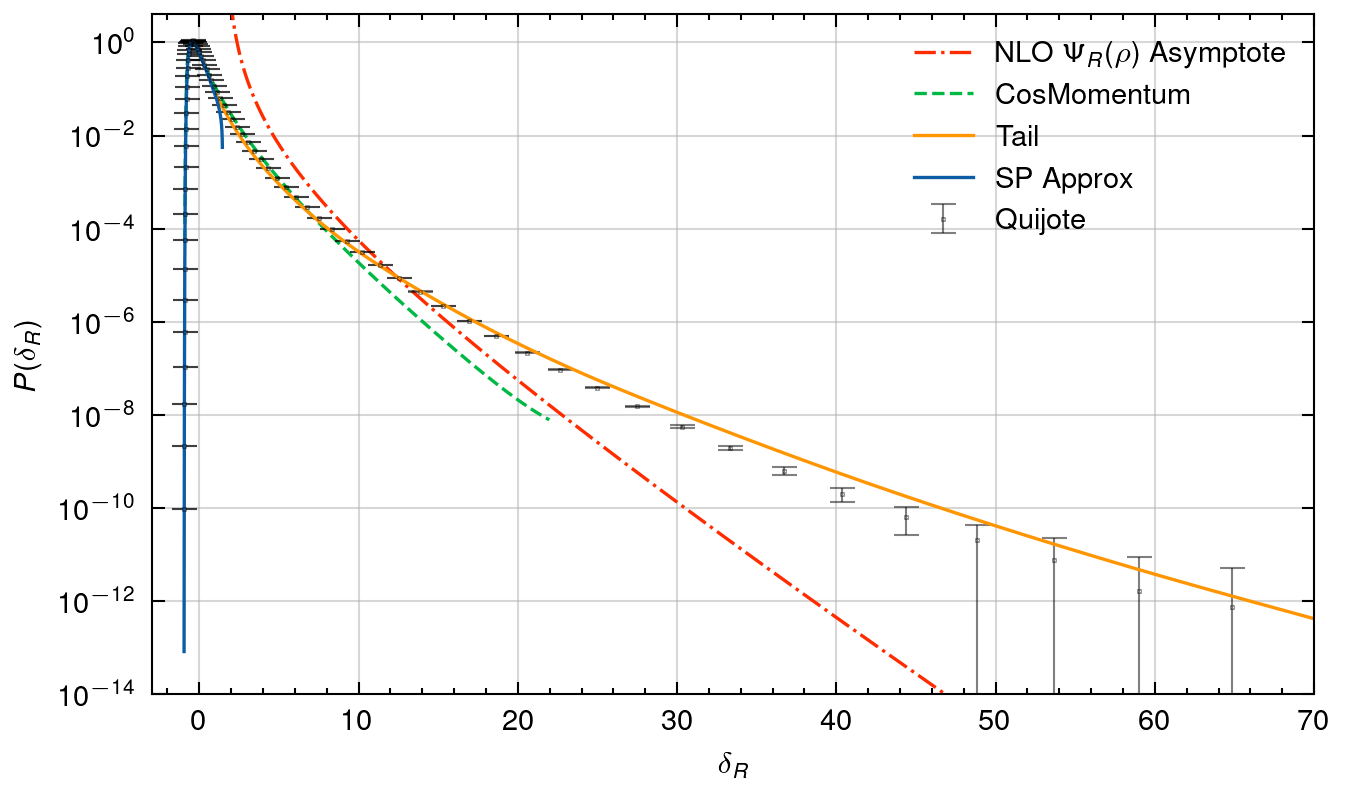

In [28]:
extra_N = 0

# plt.plot(rho_num_deriv-1,P_1,label=r"LO $\Psi_R (\rho)$ Asymptote", ls = "dotted", lw=0.8, c = colors[3])
plt.plot(rho_num_deriv-1,P_2,label=r"NLO $\Psi_R (\rho)$ Asymptote", ls = "dashdot", lw=0.8, c = colors[3])
# plt.plot(rho_num_deriv-1,P_3,label=r"NNLO $\Psi_R (\rho)$ Asymptote", ls = "dashed", lw=0.8, c = colors[3])


# plt.plot(rho_num_deriv-1,P_46,c ='steelblue',label='Saddle-Point Approx')


plt.plot(CM_delta,CM_PDF,label='CosMomentum', c = colors[1], ls='dashed')


plt.errorbar(del_qui,pdf_qui,yerr=std_qui,elinewidth = 0.5,
             linewidth = 0.0,
             marker = "s",
             markersize = 0.1,
             capsize = 3,
             capthick = 0.5,
             c = "k",
             label = "Quijote",
             alpha=0.5)


indx = int(np.where(del_R>1)[0][0])
plt.plot(del_R[1:-1][indx:-1],high_dens_tails(del_R,k_l,pk_l,R)[indx:-1],label = 'Tail', c = colors[2])


plt.plot(cgfp[:-N-extra_N],pdf_saddle[:-N-extra_N],label="SP Approx", c = colors[0])



plt.yscale("log")

# R 5 z 0.5
plt.xlim([-3,70])
plt.ylim([1e-14, 4])


plt.legend()
plt.grid(lw=0.5,alpha=0.5)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$P(\delta_R)$')
plt.savefig("figs5/PDF_z="+str(z)+"_R="+str(R)+".pdf")
plt.show()

# Many Redshift/radius plots

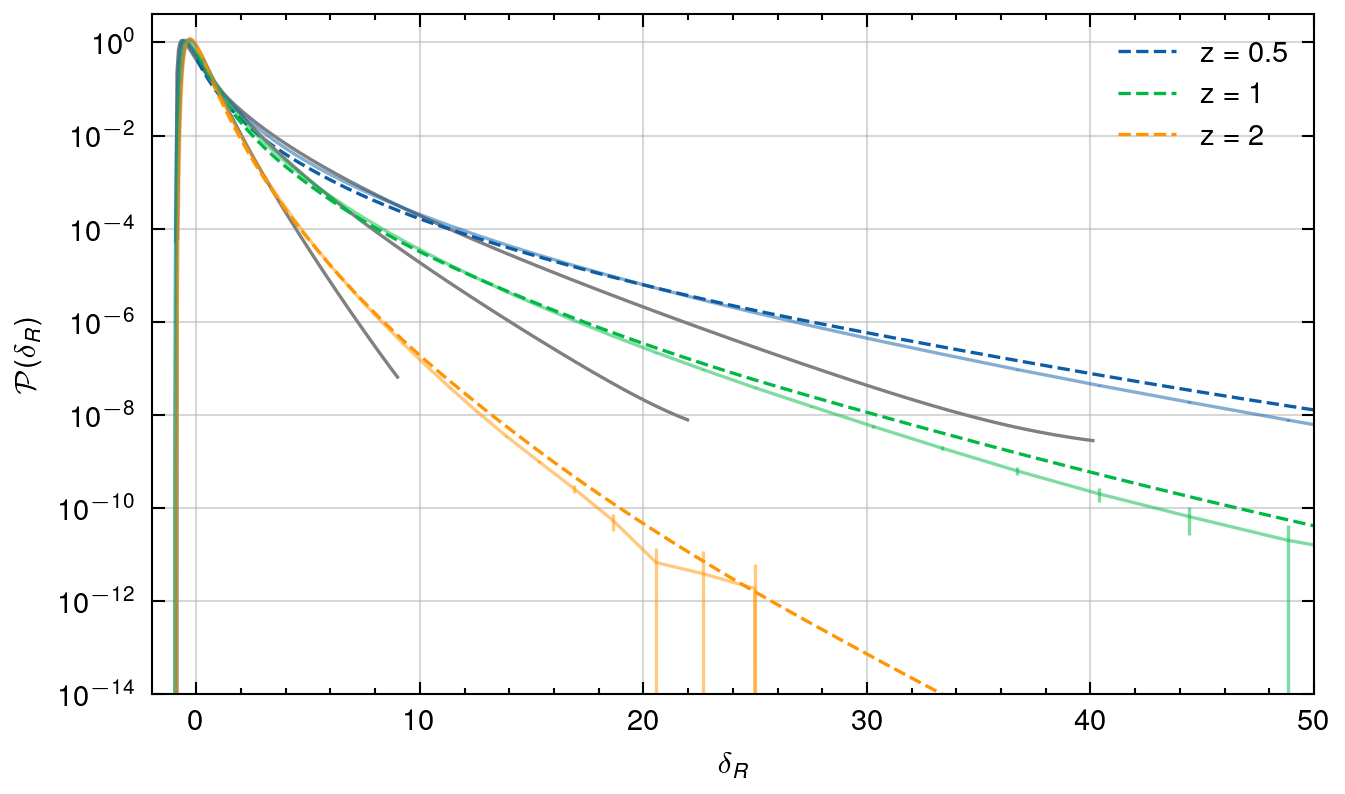

In [5]:
# Those are all the ones available now, to get more, go back and pre-calculate from cosmomentum and extract from Quijote, this range should be enough though
z_array = [0.5,1,2]
R_array = [5.0]

color_list = colors
c_ind = 0

for R in R_array:
    # print(R)
    for z in z_array:
        # print(z)
        quijote_pathname = "/project/ls-gruen/users/jamal.elkuweiss/Data/Quijote_PDFs_15000_512CDMparticles/quijote_PDF_z" + str(z) +"_R" + str(R) +".npy"
        del_qui, pdf_qui, std_qui = load_quijote_sim(quijote_pathname)
        plt.errorbar(del_qui,pdf_qui,yerr=std_qui,alpha = 0.5,c=color_list[c_ind])
        
        
        CM_delta = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/CosMom/delta_quijote_z" + str(z) +"_R" + str(int(R)) +"_CosMom.npy")
        CM_PDF = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/CosMom/PDF_quijote_z" + str(z) +"_R" + str(int(R)) +"_CosMom.npy")
        plt.plot(CM_delta,CM_PDF,c='grey')
        
        
        k_l,pk_l,k_nl,pk_nl = np.load("power_spectra_kl_pl_knl_pnl_z="+ str(z)+".npy")
        del_R = np.linspace(0,120,num=2**12)
        plt.plot(del_R[1:-1],high_dens_tails(del_R,k_l,pk_l,R),ls='dashed',c=color_list[c_ind],label="z = " + str(z))
        
        c_ind += 1
plt.yscale("log")
plt.xlim([-2,50])
plt.ylim([1e-14, 4])
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')
plt.legend()
plt.grid(lw=0.5,alpha=0.5)
# plt.title("PDF for R = 10.0 Mpc, for three redshifts, Solid lines - CosMomentum, Dotted lines - Quijote, Dashed lines - HD tails")
plt.show()

# Plotting the Heatmap of the Action

In [77]:
# # def my_function(arg_l,mod_l):
# reso = 2**10


# def F(delta):
#     nu = 21 / 13
#     return np.power((1 - (delta / nu)), -nu) - 1
#     # return np.exp(delta)-1
# def Fp(delta):
#     nu = 21/13
#     return np.power((1 -  delta/nu ),-nu-1)
#     # return np.exp(delta)

# b, a = np.meshgrid(np.linspace(-1, 1, reso), np.linspace(-1,1, reso))


# arg_l = pi/10
# mod_l = 0.4
# lam = mod_l * np.cos(arg_l) + 1j * (mod_l * np.sin(arg_l))

# a = np.array(a,dtype=np.complex_)
# b = np.array(b,dtype=np.complex_)*1j

# c = -lam*(F(a + b)) + (np.square(a + b)/2)
# # c = lam*Fp(a) - a
# c = c.real
# c = np.sign(c)

# a = a.real
# b = b.imag

# c = c[:-1, :-1]
# l_a=a.min()
# r_a=a.max()
# l_b=b.min()
# r_b=b.max()
# l_c,r_c  = -np.abs(c).max(), np.abs(c).max()

# figure, axes = plt.subplots()

# # c = axes.pcolormesh(a, b, c, vmin=l_c, vmax=r_c, cmap='bwr')
# c = axes.pcolormesh(a, b, c, vmin=-1, vmax=1, cmap='bwr')

# # axes.set_title(r'$\Re(S) = -\lambda F[\delta_L] + \delta_L^2 /2 $ for $\lambda=$' + str(np.round(lam,2)))
# axes.set_title(r'$\lambda=$' + str(np.round(lam,2)))
# axes.axis([l_a, r_a, l_b, r_b])
# figure.colorbar(c)
# plt.xlabel(r'$\Re[\tau]$')
# plt.ylabel(r'$\Im[\tau]$')
# plt.grid(c='grey',lw=0.5)
# plt.show()

In [37]:
# interact(my_function, arg_l=widgets.FloatSlider(min=-pi/4, max=pi/4, step=0.1, value=0),mod_l=widgets.FloatSlider(min=-pi/4, max=pi/4, step=0.1, value=0))

In [76]:
# plt.rcParams["figure.figsize"] = [4,3]

In [75]:
# # def my_function(arg_l,mod_l):
# reso = 2**10


# b, a = np.meshgrid(np.linspace(-1, 1, reso), np.linspace(-1,1, reso))


# arg_l = -pi/4
# mod_l = 0.5
# lam = mod_l * np.cos(arg_l) + 1j * (mod_l * np.sin(arg_l))

# a = np.array(a,dtype=np.complex_)
# b = np.array(b,dtype=np.complex_)*1j

# VLR  = np.square(sigma_from_power_spectrum(k_l, pk_l, R))

# c = np.zeros([reso,reso])

# for i in range(reso):
#     for j in range(reso):
#         mod_delta = np.abs(a[i,j] + b[i,j])
#         VLRL  = np.square(sigma_from_power_spectrum(k_l, pk_l, np.power(1 + approximate_collapse_alex(mod_delta), 1 / 3)*R))
#         ratio_for_tau = VLR/VLRL
#         c[i,j] = -lam*(approximate_collapse_alex(a[i,j] + b[i,j])) + (np.square(a[i,j] + b[i,j])/2)*ratio_for_tau
# # c = -lam*(F(a + b)) + (np.square(a + b)/2)#*ratio_for_tau
# # c = lam*Fp(a) - a
# c = c.real
# c = np.sign(c)


# a = a.real
# b = b.imag

# c = c[:-1, :-1]
# l_a=a.min()
# r_a=a.max()
# l_b=b.min()
# r_b=b.max()
# l_c,r_c  = -np.abs(c).max(), np.abs(c).max()

# figure, axes = plt.subplots()

# # c = axes.pcolormesh(a, b, c, vmin=l_c, vmax=r_c, cmap='bwr')
# c = axes.pcolormesh(a, b, c, vmin=-1, vmax=1, cmap='bwr')

# # axes.set_title(r'$\Re(S) = -\lambda F[\delta_L] + \delta_L^2 /2 $ for $\lambda=$' + str(np.round(lam,2)))
# # axes.set_title(r'$\lambda=$' + str(np.round(lam,2)))
# axes.axis([l_a, r_a, l_b, r_b])
# # figure.colorbar(c)
# plt.xlabel(r'$\Re[\delta]$')
# plt.ylabel(r'$\Im[\delta]$')
# plt.grid(c='black',lw=0.3,ls='dashed',alpha=0.8)
# plt.show()
# plt.savefig("figs5/heatmapminus.png")